# Botezlive chat classification model

In [538]:
import pandas as pd
import sklearn.feature_extraction.text as ft
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split,GridSearchCV
import sklearn.svm as svm
import sklearn.calibration as cal
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,brier_score_loss
from sklearn.metrics import plot_precision_recall_curve,classification_report
from sklearn.metrics import precision_score,roc_auc_score,log_loss
from sklearn.metrics import confusion_matrix,jaccard_score,f1_score,recall_score
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
import numpy as np
import time
import datetime
import sklearn.pipeline as pipe
from lime import lime_text
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from emotes import emotes
from sklearn.decomposition import TruncatedSVD
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling1D, Conv1D, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from wordcloud import WordCloud, STOPWORDS
stop_words=set(stopwords.words('english'))
stopwords = set(STOPWORDS)
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [506]:
#!pip3 install tensorflow

In [507]:
df = pd.read_csv("./data/botezlive_data.csv")
#tmp = pd.read_csv('./data/botezlive_dataframe.csv',low_memory=False,keep_default_na=False)

#df = tmp[['message','moderated']].copy()

In [508]:
#df.rename(columns={'message':'text','moderated':'is_offensive'},inplace=True)

**Trim features based on chi2 score**

In [509]:
def split_data(df,params):
#trim number of zeros from dataset
    df_ones = df.loc[df["is_offensive"]==1]
    df_tmp = df.loc[df["is_offensive"]==0]
        
    ratio = len(df_ones)/len(df_tmp)

    msk = np.random.rand(len(df_tmp)) < params['multiplier']*ratio
    df_zeros = df_tmp.loc[msk]
    
    df = pd.concat([df_ones,df_zeros]).reset_index(drop=True)
    df_train,df_test = train_test_split(df,test_size=0.2,random_state=0)
    
    return df_train,df_test

**Get tfidf vectorizer**

In [510]:
def get_vectorizer(df_train,params):
    vparams = dict({'stop_words':stop_words,#None,#stop_words,
                    'min_df':params['min_df'],
                    'max_df':params['max_df'],
                    'smooth_idf':params['smooth_idf'],
                    'analyzer':params['analyzer'],
                    'ngram_range':params['ngram_range'],
                    'sublinear_tf':params['sublinear_tf'],
                    'max_features':params['max_features'],
                    })
    
    vectorizer = ft.TfidfVectorizer(**vparams)
    x_train = vectorizer.fit_transform(df_train['text'])
    
    if params["trim features"]:
    
        y = df_train['is_offensive']#y_train
        x_names = vectorizer.get_feature_names()
        p_value_limit = params['pvalue limit']
    
        dtf_features = pd.DataFrame()
        for cat in np.unique(y):
            chi2, p_value = fs.chi2(x_train, y==cat)
            entry = pd.DataFrame({"feature":x_names, "score":1-p_value, "y":cat})
            dtf_features = dtf_features.append(entry)
            dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
            dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
        x_names = dtf_features["feature"].unique().tolist()   
    
        vparams['vocabulary'] = x_names
        vectorizer = ft.TfidfVectorizer(**vparams)
    
    return vectorizer

In [511]:
def get_dual_vectorizer(df_train,p1,p2):

    vec1 = get_vectorizer(df_train,p1)
    vec2 = get_vectorizer(df_train,p2)
    
    features = set(vec1.get_feature_names()) | set(vec2.get_feature_names())
    features = list(features)
    
    vectorizer = ft.TfidfVectorizer(vocabulary=features,max_features=p1['max_features'])
    
    return vectorizer
    

In [512]:
def get_pca(params):
    pca = TruncatedSVD(n_components=params['n_components'])
    #pca.fit(X)
    #principalDf = pd.DataFrame(data = principalComponents,
    #                           columns = ['%s' %(i) for i in range(n_components)])
    return pca
    

### Builds dictionary of scores based on parameter set

In [540]:
#def param_score(df,params):
def transformer(x):
    return np.array(x.toarray())

def param_score(df,params):
    
    df_train,df_test = split_data(df,params)
    vectorizer = get_vectorizer(df_train,params)
    model = get_model(params)
    
    y_train = df_train['is_offensive']
    y_test = df_test['is_offensive']
    
    num_splits = 1
    
    if params['classifier_type']=='NN': 
        
        nn = KerasClassifier(build_fn=lambda:model)
        nn._estimator_type = "classifier"
        vectorizer.fit(df_train['text'])
        num_rows = df_train.shape[0]
        num_splits = num_rows//5000 + 1
        
        print("Number of samples: %s" %num_rows)
        print("Number of splits: %s" %num_splits)
        
        if params['pca']:
            pca = get_pca(params)
        #    pca.fit(vectorizer.transform(df_train['text']))            

        if num_splits == 1 and params['pca']:
            my_pipeline = pipe.Pipeline([('vectorizer',vectorizer),
                                         ('pca',pca),
                                         ('classifier',nn)])
            my_pipeline.fit(df_train['text'],df_train['is_offensive'],
                            classifier__verbose=1,
                            classifier__epochs=params['epochs'],
                            classifier__batch_size=4)
        
        if num_splits == 1 and ~params['pca']:
            my_pipeline = pipe.Pipeline([('vectorizer',vectorizer),
                                         ('transformer',FunctionTransformer(transformer)),
                                         ('classifier',nn)])
            my_pipeline.fit(df_train['text'],df_train['is_offensive'],
                            classifier__verbose=1,
                            classifier__epochs=params['epochs'],
                            classifier__batch_size=4)
            
        if num_splits > 1 and params['pca']:
            pca.fit(vectorizer.transform(df_train['text'])) 
            df_array = np.array_split(df_train,num_splits)
            for i in range(num_splits):
                print("Split number: %s" %i)
                df_tmp = df_array[i]
                nn.fit(pca.transform(vectorizer.transform(df_tmp['text'])),
                       df_tmp['is_offensive'],verbose=1,
                       epochs=params['epochs'],batch_size=4)
            my_pipeline = pipe.Pipeline([('vectorizer',vectorizer),
                                         ('pca',pca),
                                         ('classifier',nn)])    
                
        if num_splits > 1 and ~params['pca']:
            df_array = np.array_split(df_train,num_splits)
            for i in range(num_splits):
                print("Split number: %s" %i)
                df_tmp = df_array[i]
                nn.fit(transformer(vectorizer.transform(df_tmp['text'])),
                       df_tmp['is_offensive'],verbose=1,
                       epochs=params['epochs'],batch_size=4)
            my_pipeline = pipe.Pipeline([('vectorizer',vectorizer),
                                         ('transformer',FunctionTransformer(transformer)),
                                         ('classifier',nn)])         
        
    else:# params['classifier_type']=='SVM': 
        clf = cal.CalibratedClassifierCV(model,cv=p1['cv'],method='sigmoid')
        if params['pca']:
            pca = get_pca(params)
            my_pipeline = pipe.Pipeline([('vectorizer',vectorizer),
                                         ('pca',pca),
                                         ('classifier',clf)])
    
        else:       
            my_pipeline = pipe.Pipeline([('vectorizer',vectorizer),
                                         ('classifier',clf)])
    
        my_pipeline.fit(df_train['text'],df_train['is_offensive'])
    
    score = my_pipeline.score(df_test['text'],df_test['is_offensive'])
    print('test accuracy: %s' %score)

    discrete_preds = my_pipeline.predict(df_test['text'])
    confusion = confusion_matrix(y_test,discrete_preds)
    
    test_ones = sum(confusion[1][:])
    test_zeros = sum(confusion[0][:])
    
    scores = dict({'classifier_type':params['classifier_type'],
                   'splits':num_splits,
                   'n_samples':df_train.shape[0],
                   'ngram_range':params['ngram_range'],
                   'pca':params['pca'],
                   'n_components':params['n_components'],
                   'max_features':params['max_features'],
                   'trim features':params['trim features'],
                   'pvalue limit':params['pvalue limit'],
                   'multiplier':params['multiplier'],
                   'precision':precision_score(y_test,discrete_preds),
                   'jaccard':jaccard_score(y_test,discrete_preds),
                   'recall':recall_score(y_test,discrete_preds),
                   'F1':f1_score(y_test,discrete_preds),
                   'TP':confusion[1][1]/test_ones,
                   'FP':confusion[0][1]/test_zeros,
                   'TN':confusion[0][0]/test_zeros,
                   'FN':confusion[1][0]/test_ones,                   
                  })
    
    return my_pipeline,discrete_preds,df_train,df_test,scores

**Neural network model**

In [539]:
def get_model(params):
    
    if params['classifier_type'] == 'NN':
        if params['pca']: feature_num = params['n_components']
        else: feature_num = params['max_features']    
    
        model = Sequential()
        #model.add(Embedding(feature_num,128))
        #model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2))
        model.add(Dense(128,activation='relu',
              input_shape=(feature_num,)))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
   
        model.summary()
    
    if params['classifier_type'] == 'SVM':
        cparams = dict({'max_iter':1000,'C':params['C'],'class_weight':params['class_weight']})
        model = svm.LinearSVC(**cparams)
        
    if params['classifier_type'] == 'RFC':
        model = RandomForestClassifier()
        

    return model#KerasClassifier(model_nn)

### Goes through each parameter set and builds dataframe with accuracy scores

In [516]:
headers = ['classifier_type',
           'splits',
           'n_samples',
           'ngram_range',
           'trim features',
           'pca','n_components',
           'max_features',
           'pvalue limit',
           'multiplier',
           'precision',
           'jaccard',
           'recall',
           'F1',
           'TP', 'FP','TN','FN']
df_scores = pd.DataFrame(columns=headers)

In [ ]:
p1 = dict({'classifier_type':'SVM',
           'min_df':1,
           'max_df':0.9,
           'smooth_idf':1,
           'sublinear_tf':1,
           'ngram_range':(2,10),
           'max_features':None,
           'C':1.0,
           'cv':5,
           'analyzer':'char_wb',
           'trim features':False,
           'pvalue limit':0.4,
           'class_weight':None,
           'multiplier':1,
           'n_components':400,
           'epochs':10,
           'pca':False})

p2 = p1.copy()
p2['classifier_type'] = 'NN'
p2['max_features'] = 20000
p2['pca'] = True

In [542]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [548]:
params_list = [p1]

for i,p in enumerate(params_list):
    
    start = time.time()
    model,discrete_preds,df_train,df_test,scores = param_score(df.sample(100000),p)
    df_scores = df_scores.append(scores,ignore_index=True)

    end = time.time()
    elapsed = end - start
    
    remaining_seconds = elapsed*(len(params_list)-i-1)
    print("Done: {:.5f}, Remaining: {:<25}".format((i+1)/len(params_list),str(datetime.timedelta(seconds=remaining_seconds))),end="\r")

KeyboardInterrupt: 

### Average of accuracy scores

In [547]:
df_scores["avg score"]=df_scores[['precision','recall','jaccard','F1','TP','TN']].values.mean(axis=1)
df_scores

classifier_type splits n_samples ngram_range trim features    pca  \
0              NN      6     58747     (2, 10)         False  False   
1              NN     19     94010     (2, 10)         False  False   
2             SVM      0     94256     (2, 10)         False  False   
3             RFC      1      1009     (2, 10)         False  False   
4             RFC      1      9316     (2, 10)         False  False   

  n_components max_features  pvalue limit multiplier  precision   jaccard  \
0          400        20000           0.4          1   0.826740  0.692073   
1          400        20000           0.4          1   0.809897  0.687196   
2          400         None           0.4          1   0.870533  0.768516   
3          400         None           0.4          1   0.688000  0.544304   
4          400         None           0.4          1   0.804444  0.661066   

     recall        F1        TP        FP        TN        FN  avg score  
0  0.809478  0.818018  0.809478  0.166734  0.833266  0.190522   0.798175  
1  0.819360  0.814601  0.819360  0.191459  0.808541  0.180640   0.793159  
2  0.867688  0.869108  0.867688  0.125628  0.874372  0.132312   0.852984  
3  0.722689  0.704918  0.722689  0.291045  0.708955  0.277311   0.681926  
4  0.787641  0.795954  0.787641  0.186441  0.813559  0.212359   0.775051

### Select parameter set with highest average accuracy

In [521]:
df_scores.sort_values(by='avg score', ascending=False, inplace=True)
df_scores.head(1)

#df_scores.loc[0,'avg score']

classifier_type splits n_samples ngram_range trim features    pca  \
0              NN      6     58747     (2, 10)         False  False   

  n_components max_features  pvalue limit multiplier  precision   jaccard  \
0          400        20000           0.4          1    0.82674  0.692073   

     recall        F1        TP        FP        TN        FN  avg score  
0  0.809478  0.818018  0.809478  0.166734  0.833266  0.190522   0.798175

### Classification explainer

In [532]:
txt_instance = "its so hot outside"

explainer = lime_text.LimeTextExplainer(class_names=
            np.unique(df_train['is_offensive']))
explained = explainer.explain_instance(txt_instance, 
            model.predict_proba, num_features=5)
explained.show_in_notebook(text=txt_instance, predict_proba=True)

### Plot evaluation curves and confusion matrix

In [533]:
def plot_score_curves(clf,X,Y):
     
    ax = plt.gca()

    preds = clf.predict_proba(X)[:,1]
    discrete_preds = clf.predict(X)
    
    clf_score = brier_score_loss(Y,preds,pos_label=1)
    frac_of_positives,mean_predicted_value = cal.calibration_curve(Y,preds,n_bins=20)
    ax.plot(mean_predicted_value,frac_of_positives,"s-",label="Sigmoid calibration (Brier loss={:.4f})".format(clf_score))

    clf_score = brier_score_loss(Y,discrete_preds,pos_label=1)
    frac_of_positives,mean_predicted_value = cal.calibration_curve(Y,discrete_preds,n_bins=20)
    ax.plot(mean_predicted_value,frac_of_positives,"s-",label="Discrete predictions (Brier loss={:.4f})".format(clf_score))

    ax.plot([0,1],[0,1],"s--",label="Perfectly calibrated".format(clf_score))

    plt.legend()
    
    plot_roc_curve(clf,X,Y)
    
    plot_precision_recall_curve(clf,X,Y)
    
    plot_confusion_matrix(clf,X,Y)
    

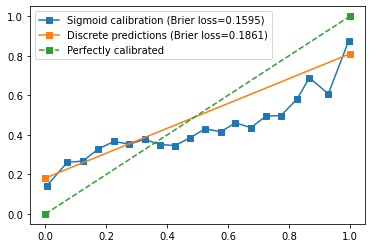

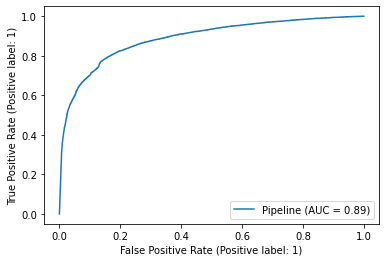

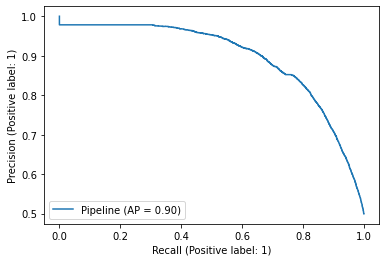

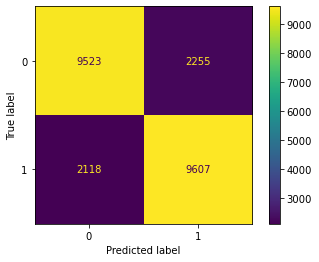

In [534]:
plot_score_curves(model,df_test['text'],df_test['is_offensive'])

In [ ]:
def clean_text(row):
    words = []
    for w in row.split():
        word = re.sub('[^A-Za-z0-9]+', '', str(w))
        words.append(word.lower())
    return words

def get_words(df,text_label='text',target_label='is_offensive',value=0):
    words = []
    for row in df[df[target_label]==value].iloc[:][text_label]:
        words += clean_text(row)
    return ' '.join(words)    

def get_wordcloud(df,text_label='text',target_label='is_offensive',value=0):
    words = get_words(df,text_label=text_label,target_label=target_label,value=value)
    wc = WordCloud(background_color='white',
                   max_words=500,
                   stopwords=stopwords)
    wc.generate(words)
    return wc

In [ ]:
fig = plt.figure(figsize=(15,10))

df_samp = df_train

df_samp['prediction'] = discrete_preds

for i in range(4):
    fig.add_subplot(2,2,i+1)
    #try:
    label = (i+1) % 2
    
    if 0 <= i <= 1:
        wc = get_wordcloud(df_samp,text_label='text',target_label='is_offensive',value=label)
        plt.title('Ground Truth: %s' %label)
    else:   
        wc = get_wordcloud(df_samp,text_label='text',target_label='prediction',value=label)
        plt.title('Prediction: %s' %label)
   #fig = plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    #except:
     #   pass
    
plt.show()